In [1]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier,GradientBoostingClassifier
import numpy as np
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier

liverpool_red = '#c8102E'
chelsea_blue = '#034694'
mancity_blue = '#6CABDD'
tottenham_blue = '#132257'
manutd_red ='#DA291C'

In [2]:
%matplotlib inline
import os
import operator
import numpy as np
import pandas as pd
from football_loader import metrics


def load_league_csv(league, start_year=2005):
    df = None
    files = os.listdir(f'fulldata/{league}')
    files.sort()
    for file in files:
        year = int(file.strip('.csv'))
        if year < start_year:
            continue
        df_year = pd.read_csv(f'fulldata/{league}/' + file,
                              engine='python',
                              # skiprows=1,
                              # index_col=None,
                              # names=['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'B365H', 'B365D', 'B365A']
                              )
        df_year.reset_index(drop=True, inplace=True)
        df_year['Year'] = year
        df_year['Match'] = df_year.index + 1

        if df is None:
            df = df_year
        else:
            df = df.append(df_year, ignore_index=True, sort=False)

    # print(len(df))
    # print(df.shape)

    # remove unused columns
    # df_league = None
    df.reset_index(inplace=True)
    # df = df[['Year', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR',
    #          "B365H", "B365D", "B365A"]]
    return df


def make_features(df, teams):
    # df_league = None
    ret = {}

    # if teams is None:
    #     teams = np.unique(df.loc[df['Year'] == predict_year, 'HomeTeam'].values)
    #     teams.sort()
    for team in teams:

        df_team = df[(df['HomeTeam'] == team) | (df['AwayTeam'] == team)]
        all = pd.DataFrame(
            data={
                'Year': df_team['Year'],
                'Date': df_team['Date'],
                'Team': team,
                'HomeMatch': df_team['HomeTeam'] == team
            }
        )
        all['Opponent'] = np.where(all['HomeMatch'], df_team['AwayTeam'], df_team['HomeTeam'])
        # X['HalfTimeGoals'] = np.where(X['HomeMatch'], df_team['HTHG'], df_team['HTAG'])
        # X['HalfTimeOpponentGoals'] = np.where(X['HomeMatch'], df_team['HTAG'], df_team['HTHG'])
        # X['HalfTimeLead'] = X['HalfTimeGoals'] > X['HalfTimeOpponentGoals']
        # X['HalfTimeLeadMoreThanTwo'] = (X['HalfTimeGoals'] - X['HalfTimeOpponentGoals']) > 2
        # X['FullTimeGoals'] = np.where(X['HomeMatch'], ath_madrid['FTHG'], ath_madrid['FTAG'])
        # X['FullTimeOpponentGoals'] = np.where(X['HomeMatch'], ath_madrid['FTAG'], ath_madrid['FTHG'])
        all['FTR'] = df_team['FTR']
        # all['Won'] = np.where(all['HomeMatch'], df_team['FTR'] == 'H', df_team['FTR'] == 'A')
        all['Won'] = np.where(df_team['FTR'] == '', False, np.where(all['HomeMatch'], df_team['FTR'] == 'H', df_team['FTR'] == 'A'))
        all['Draw'] = np.where(df_team['FTR'] == '', False, df_team['FTR'] == 'D')
        all['Lost'] = np.where(df_team['FTR'] == '', False, np.where(all['HomeMatch'], df_team['FTR'] == 'A', df_team['FTR'] == 'H'))
        all['Result'] = np.where(df_team['FTR'] == '', '', np.where(all['Won'], 'Win', (np.where(all['Lost'], 'Lose', 'Draw'))))
        # X['SumGoals'] = X.groupby('Opponent')['FullTimeGoals'].transform(sum)
        all['B365Max'] = np.maximum(np.maximum(df_team['B365H'], df_team['B365A']), df_team['B365D'])
        all['B365Min'] = np.minimum(np.minimum(df_team['B365H'], df_team['B365A']), df_team['B365D'])
        all['B365Say'] = np.where(all['HomeMatch'],
                                  # home match
                                  np.where(all['B365Max'] == df_team['B365H'], -1,
                                           np.where(all['B365Max'] == df_team['B365A'], 1,
                                                    0)),
                                  # away match
                                  np.where(all['B365Max'] == df_team['B365H'], 1,
                                           np.where(all['B365Max'] == df_team['B365A'], -1,
                                                    0))
                                  )
        # all['B365Diff'] = np.where(all['B365Say'] == 1, all['B365Max'] - all['B365Min'],
        #                            all['B365Min'] - all['B365Max'])
        all['B365Diff'] = np.where(all['B365Say'] == 1, all['B365Min'] - all['B365Max'],
                                   np.where(all['B365Say'] == -1, all['B365Max'] - all['B365Min'],
                                            # draw
                                            np.where(all['HomeMatch'],
                                            df_team['B365A'] - df_team['B365H'],
                                            df_team['B365H'] - df_team['B365A']
                                            ))) * -1
        all['Corners'] = np.where(all['HomeMatch'], df_team['HC'], df_team['AC'])
        all['Shots'] = np.where(all['HomeMatch'], df_team['HS'], df_team['AS'])
        all['ShotsOnTarget'] = np.where(all['HomeMatch'], df_team['HST'], df_team['AST'])
        all['Points'] = np.where(all['Won'], 3,
                                 np.where(all['Draw'], 1, 0)
                                  )
        all['AdjustedPoints'] = np.where(all['HomeMatch'],
                                  # home match
                                         np.where(all['Won'], 1,
                                                  np.where(all['Draw'], 0, -1)
                                                  )
                                         ,
                                  # away match
                                         np.where(all['Won'], 1.5,
                                                  np.where(all['Draw'], 0.5, 0)
                                                  )
                                  )
        all['Goals'] = np.where(all['HomeMatch'], df_team['FTHG'], df_team['FTAG'])
        all['Conceded'] = np.where(all['HomeMatch'], df_team['FTAG'], df_team['FTHG'])

        # find number of times won against this opponent in last 5 meetings
        for key, groupByOpponent in all.groupby('Opponent'):
            # keep index as new a column, will be restored and assigned back to X later
            idx = groupByOpponent.index

            # make match day an index because rolling need an index date
            xx = groupByOpponent.set_index('Date')
            xx['idx'] = idx
            # shift to exclude self
            xx['Last5AgainstThisOpponentWon'] = xx['Won'].rolling(6).apply(lambda x: np.nansum(x.shift()), raw=False)
            xx['Last5AgainstThisOpponentDraw'] = xx['Draw'].rolling(6).apply(lambda x: np.nansum(x.shift()), raw=False)
            # xx['Last5AgainstThisOpponentLost'] = xx['Lost'].rolling(6).apply(lambda x: np.nansum(x.shift()), raw=False)

            xx['Last3AgainstThisOpponentWon'] = xx['Won'].rolling(4).apply(lambda x: np.nansum(x.shift()), raw=False)
            xx['Last3AgainstThisOpponentDraw'] = xx['Draw'].rolling(4).apply(lambda x: np.nansum(x.shift()), raw=False)

            xx['LastAgainstThisOpponentWon'] = xx['Won'].rolling(2).apply(lambda x: np.nansum(x.shift()), raw=False)
            xx['LastAgainstThisOpponentDraw'] = xx['Draw'].rolling(2).apply(lambda x: np.nansum(x.shift()), raw=False)
            # xx['LastThisOpponentLost'] = xx['Lost'].rolling(2).apply(lambda x: np.nansum(x.shift()), raw=False)

            # restore index
            xx = xx.set_index('idx')

            # assign back to the big dataframe
            all.loc[xx.index, 'Last5AgainstThisOpponentWon'] = xx['Last5AgainstThisOpponentWon']
            all.loc[xx.index, 'Last5AgainstThisOpponentDraw'] = xx['Last5AgainstThisOpponentDraw']
            # X.loc[xx.index, 'Last5AgainstThisOpponentLost'] = xx['Last5AgainstThisOpponentLost']
            all.loc[xx.index, 'Last3AgainstThisOpponentWon'] = xx['Last3AgainstThisOpponentWon']
            all.loc[xx.index, 'Last3AgainstThisOpponentDraw'] = xx['Last3AgainstThisOpponentDraw']
            all.loc[xx.index, 'LastAgainstThisOpponentWon'] = xx['LastAgainstThisOpponentWon']
            all.loc[xx.index, 'LastAgainstThisOpponentDraw'] = xx['LastAgainstThisOpponentDraw']
            # X.loc[xx.index, 'LastThisOpponentLost'] = xx['LastThisOpponentLost']

        # stats by year/season
        for year, groupByYear in all.groupby('Year'):
            # print(year)
            # keep index as new a column, will be restored and assigned back to X later
            idx = groupByYear.index

            # make match day an index because rolling need an index date
            xx = groupByYear.set_index('Date')
            xx['idx'] = idx

            # shift to exclude self
            xx['CornersSoFar'] = np.nancumsum(xx['Corners'].shift())
            xx['ShotsSoFar'] = np.nancumsum(xx['Shots'].shift())
            xx['ShotsOnTargetSoFar'] = np.nancumsum(xx['ShotsOnTarget'].shift())
            xx['GoalsSoFar'] = np.nancumsum(xx['Goals'].shift())
            xx['ConcededSoFar'] = np.nancumsum(xx['Conceded'].shift())

            xx['HomeWonNum'] = np.where(xx['HomeMatch'] & xx['Won'], 1, 0)
            xx['HomeWonSoFar'] = np.nancumsum(xx['HomeWonNum'].shift())
            xx['AwayWonNum'] = np.where((xx['HomeMatch'] == False) & xx['Won'], 1, 0)
            xx['AwayWonSoFar'] = np.nancumsum(xx['AwayWonNum'].shift())

            xx['PointsSoFar'] = np.nancumsum(xx['Points'].shift())
            xx['AdjustedPointsSoFar'] = np.nancumsum(xx['AdjustedPoints'].shift())

            # restore index
            xx = xx.set_index('idx')

            # assign back to the big dataframe
            # all.loc[xx.index, 'CornersSoFar'] = xx['CornersSoFar']
            # all.loc[xx.index, 'ShotsSoFar'] = xx['ShotsSoFar']
            # all.loc[xx.index, 'ShotsOnTargetSoFar'] = xx['ShotsOnTargetSoFar']
            # all.loc[xx.index, 'GoalsSoFar'] = xx['GoalsSoFar']
            # all.loc[xx.index, 'ConcededSoSoFar'] = xx['ConcededSoSoFar']
#             all.loc[xx.index, 'HomeWonSoFar'] = xx['HomeWonSoFar']
#             all.loc[xx.index, 'AwayWonSoFar'] = xx['AwayWonSoFar']
            all.loc[xx.index, 'PointsSoFar'] = xx['PointsSoFar']
            all.loc[xx.index, 'AdjustedPointsSoFar'] = xx['AdjustedPointsSoFar']

        # find recent forms
        idx = all.index
        xx = all.set_index('Date')
        xx['idx'] = idx
        xx['Last5Won'] = xx['Won'].rolling(6).apply(lambda x: np.nansum(x.shift()), raw=False)
        xx['Last5Draw'] = xx['Draw'].rolling(6).apply(lambda x: np.nansum(x.shift()), raw=False)
        # xx['Last5Lost'] = xx['Lost'].rolling(6).apply(lambda x: np.nansum(x.shift()), raw=False)
        xx['Last3Won'] = xx['Won'].rolling(4).apply(lambda x: np.nansum(x.shift()), raw=False)
        xx['Last3Draw'] = xx['Draw'].rolling(4).apply(lambda x: np.nansum(x.shift()), raw=False)
        xx['LastWon'] = xx['Won'].rolling(2).apply(lambda x: np.nansum(x.shift()), raw=False)
        xx['LastDraw'] = xx['Draw'].rolling(2).apply(lambda x: np.nansum(x.shift()), raw=False)

        # restore index
        xx = xx.set_index('idx')
        # assign back to the big dataframe
        all.loc[xx.index, 'Last5Won'] = xx['Last5Won']
        all.loc[xx.index, 'Last5Draw'] = xx['Last5Draw']
        all.loc[xx.index, 'Last3Won'] = xx['Last3Won']
        all.loc[xx.index, 'Last3Draw'] = xx['Last3Draw']
        all.loc[xx.index, 'LastWon'] = xx['LastWon']
        all.loc[xx.index, 'LastDraw'] = xx['LastDraw']
        # X.loc[xx.index, 'Last5Lost'] = xx['Last5Lost']

        # replace nan with 0
        # TODO: better way to handle nan
        # all.loc[np.isnan(all['FTR']), 'FTR'] = ''
        all.loc[np.isnan(all['Last5AgainstThisOpponentWon']), 'Last5AgainstThisOpponentWon'] = 0
        all.loc[np.isnan(all['Last5AgainstThisOpponentDraw']), 'Last5AgainstThisOpponentDraw'] = 0
        # X.loc[np.isnan(X['Last5AgainstThisOpponentLost']), 'Last5AgainstThisOpponentLost'] = 0
        all.loc[np.isnan(all['Last3AgainstThisOpponentWon']), 'Last3AgainstThisOpponentWon'] = 0
        all.loc[np.isnan(all['Last3AgainstThisOpponentDraw']), 'Last3AgainstThisOpponentDraw'] = 0
        all.loc[np.isnan(all['LastAgainstThisOpponentWon']), 'LastAgainstThisOpponentWon'] = 0
        all.loc[np.isnan(all['LastAgainstThisOpponentDraw']), 'LastAgainstThisOpponentDraw'] = 0
        # X.loc[np.isnan(X['LastThisOpponentLost']), 'LastThisOpponentLost'] = 0
        all.loc[np.isnan(all['Last5Won']), 'Last5Won'] = 0
        all.loc[np.isnan(all['Last5Draw']), 'Last5Draw'] = 0
        # X.loc[np.isnan(X['Last5Lost']), 'Last5Lost'] = 0
        all.loc[np.isnan(all['Last3Won']), 'Last3Won'] = 0
        all.loc[np.isnan(all['Last3Draw']), 'Last3Draw'] = 0
        all.loc[np.isnan(all['LastWon']), 'LastWon'] = 0
        all.loc[np.isnan(all['LastDraw']), 'LastDraw'] = 0
        all.loc[np.isnan(all['B365Diff']), 'B365Diff'] = 0

        # restrict training data (too old data may not be irrelevance)
        X = all
        Y = X[['Result']]
        # del X['Result']
        # X = all.loc[(all['Year'] >= train_year) & (all['Year'] < predict_year)]
        # Y = all[['Result']]

        # split data into train - test sets
        # x_train = X[(X['Year'] < predict_year)]
        # y_train = Y[(X['Year'] < predict_year)]
        # x_test = X[(X['Year'] >= predict_year)]
        # y_test = Y[(X['Year'] >= predict_year)]
        # X['Predict'] = ''
        close_leaks(X)
        ret[team] = [X, Y]
    return ret


# call this after you've split data
def close_leaks(X):
    # remove duplicate features
#     del X['LastWon']
#     del X['LastDraw']

    # prevent future leaks
    # result = pd.DataFrame(X['Result'])
    del X['Result']
    del X['Lost']
    del X['Draw']
    del X['Won']
    del X['FTR']
    del X['Date']
    del X['Opponent']
    del X['Team']
    del X['B365Max']
    del X['B365Min']
    del X['Corners']
    del X['Shots']
    del X['ShotsOnTarget']
    del X['Points']
    del X['AdjustedPoints']
    del X['Goals']
    del X['Conceded']


In [3]:
league = 'english'
validate_year = 2016
test_year = 2017
train_year = 2005
df = load_league_csv(league)

In [4]:
teams = df.loc[(df['Year'] == validate_year) | (df['Year'] == test_year), 'HomeTeam']
teams = teams.unique()
teams.sort()
print(teams)
print(len(teams))

['Arsenal' 'Bournemouth' 'Brighton' 'Burnley' 'Chelsea' 'Crystal Palace'
 'Everton' 'Huddersfield' 'Hull' 'Leicester' 'Liverpool' 'Man City'
 'Man United' 'Middlesbrough' 'Newcastle' 'Southampton' 'Stoke'
 'Sunderland' 'Swansea' 'Tottenham' 'Watford' 'West Brom' 'West Ham']
23


In [5]:
teams = make_features(df, teams)
classes = ['Draw', 'Lose', 'Win']

In [6]:
print('X')
print(teams[next(iter(teams))][0].count()) # X
print('Y')
print(teams[next(iter(teams))][1].count()) # Y
print(len(teams), 'teams')

X
Year                            494
HomeMatch                       494
B365Say                         494
B365Diff                        494
Last5AgainstThisOpponentWon     494
Last5AgainstThisOpponentDraw    494
Last3AgainstThisOpponentWon     494
Last3AgainstThisOpponentDraw    494
LastAgainstThisOpponentWon      494
LastAgainstThisOpponentDraw     494
PointsSoFar                     494
AdjustedPointsSoFar             494
Last5Won                        494
Last5Draw                       494
Last3Won                        494
Last3Draw                       494
LastWon                         494
LastDraw                        494
dtype: int64
Y
Result    494
dtype: int64
23 teams


In [7]:
total = None
for team in teams:
# for team in ['Arsenal']:
    X = teams[team][0]
    Y = teams[team][1]
    # split data into train - validate - test sets
    x_train = X[(X['Year'] >= train_year) & (X['Year'] < validate_year)]
    y_train = Y[(X['Year'] >= train_year) & (X['Year'] < validate_year)]
    x_validate = X[(X['Year'] >= validate_year) & (X['Year'] < test_year)]
    y_validate = Y[(X['Year'] >= validate_year) & (X['Year'] < test_year)]
    x_test = X[(X['Year'] >= test_year)]
    y_test = Y[(X['Year'] >= test_year)]
    if len(x_train) <= 0 or len(x_test) <= 0 or len(x_validate) <= 0:
        print(f'skip {team}')
        continue
    
    validate_accuracies = {}
    test_accuracies = {}
    
    lr = LogisticRegression()
    lr.fit(x_train, y_train['Result'])
    y_validate_pred = lr.predict(x_validate)
    validate_accuracies['LogisticRegression'] = accuracy_score(y_validate, y_validate_pred) * 100
    y_test_pred = lr.predict(x_test)
    test_accuracies['LogisticRegression'] = accuracy_score(y_test, y_test_pred) * 100
    d = pd.DataFrame(
        data={
            'Year': x_validate['Year'].append(x_test['Year']),
            'Team': team,
            'Predict': np.append(y_validate_pred, y_test_pred),
            'Actual': y_validate['Result'].append(y_test['Result'])
        },
        index=np.append(y_validate.index, y_test.index)
#         index=pd.MultiIndex.from_tuples(
#             list(zip(np.repeat('LogisticRegression', len(y_test.index)), y_test.index.values)),
#             names=['predictor', 'match_id'])
    )
    if total is None:
        total = d
    else:
        total = total.append(d)
    for (k, v) in validate_accuracies.items():
        print(f"{k}: {team} validation accuracy are: {v}")
#         cm = confusion_matrix(y_validate, y_validate_pred, labels=classes)
#         metrics.plot_confusion_matrix(cm, classes, title=team)
        print(f"{k}: {team} test accuracy are: {test_accuracies[k]}")
#         cm = confusion_matrix(y_test, y_test_pred, labels=classes)
#         metrics.plot_confusion_matrix(cm, classes, title=team)
#     print(lr.coef_)
    


LogisticRegression: Arsenal validation accuracy are: 63.1578947368421
LogisticRegression: Arsenal test accuracy are: 63.1578947368421
LogisticRegression: Bournemouth validation accuracy are: 55.26315789473685
LogisticRegression: Bournemouth test accuracy are: 50.0
skip Brighton
LogisticRegression: Burnley validation accuracy are: 52.63157894736842
LogisticRegression: Burnley test accuracy are: 34.21052631578947
LogisticRegression: Chelsea validation accuracy are: 78.94736842105263
LogisticRegression: Chelsea test accuracy are: 52.63157894736842
LogisticRegression: Crystal Palace validation accuracy are: 44.73684210526316
LogisticRegression: Crystal Palace test accuracy are: 55.26315789473685
LogisticRegression: Everton validation accuracy are: 42.10526315789473
LogisticRegression: Everton test accuracy are: 68.42105263157895
skip Huddersfield
skip Hull
LogisticRegression: Leicester validation accuracy are: 44.73684210526316
LogisticRegression: Leicester test accuracy are: 42.1052631578

In [8]:
# for key, groupByPredictor in total.groupby('predictor'):
#     print(f"{key} overall accuracy is ", accuracy_score(groupByPredictor['actual'], groupByPredictor['pred'])*100)
print(f"Overall accuracy is ", accuracy_score(total['Actual'], total['Predict'])*100)

Overall accuracy is  53.40557275541795


In [9]:
total

,Year,Team,Predict,Actual
4188,2016,Arsenal,Win,Lose
4193,2016,Arsenal,Win,Draw
4208,2016,Arsenal,Win,Win
4211,2016,Arsenal,Win,Win
4223,2016,Arsenal,Win,Win
4231,2016,Arsenal,Draw,Win
4247,2016,Arsenal,Win,Win
4251,2016,Arsenal,Win,Win
4261,2016,Arsenal,Win,Draw
4274,2016,Arsenal,Win,Win


In [10]:
%matplotlib inline
import seaborn as sns
sns.set()

In [11]:
arsenal = pd.DataFrame(teams['Arsenal'][0])
arsenal = arsenal[(arsenal['Year'] >= validate_year) | (arsenal['Year'] >= test_year)]
arsenal['Actual'] = teams['Arsenal'][1]['Result']
i = total[total.index.isin(arsenal.index)]
arsenal.loc[i.index, 'Predict'] = i['Predict']
arsenal

,Year,HomeMatch,B365Say,B365Diff,Last5AgainstThisOpponentWon,Last5AgainstThisOpponentDraw,Last3AgainstThisOpponentWon,Last3AgainstThisOpponentDraw,LastAgainstThisOpponentWon,LastAgainstThisOpponentDraw,PointsSoFar,AdjustedPointsSoFar,Last5Won,Last5Draw,Last3Won,Last3Draw,LastWon,LastDraw,Actual,Predict
4188,2016,True,0,-0.70,1.0,3.0,1.0,2.0,0.0,1.0,0.0,0.0,3.0,2.0,2.0,1.0,1.0,0.0,Lose,Draw
4193,2016,False,0,-0.38,0.0,0.0,3.0,0.0,1.0,0.0,0.0,-1.0,2.0,2.0,1.0,1.0,0.0,0.0,Draw,Lose
4208,2016,False,1,3.27,0.0,0.0,3.0,0.0,1.0,0.0,1.0,-0.5,2.0,2.0,1.0,1.0,0.0,1.0,Win,Lose
4211,2016,True,1,4.93,1.0,2.0,0.0,1.0,0.0,1.0,4.0,1.0,2.0,2.0,1.0,1.0,1.0,0.0,Win,Lose
4223,2016,False,1,4.40,4.0,1.0,2.0,1.0,1.0,0.0,7.0,2.0,3.0,1.0,2.0,1.0,1.0,0.0,Win,Win
4231,2016,True,0,-0.70,0.0,1.0,0.0,1.0,0.0,0.0,10.0,3.5,3.0,1.0,3.0,0.0,1.0,0.0,Win,Win
4247,2016,False,1,7.60,0.0,0.0,3.0,0.0,1.0,0.0,13.0,4.5,4.0,1.0,3.0,0.0,1.0,0.0,Win,Draw
4251,2016,True,1,9.71,1.0,1.0,1.0,0.0,0.0,0.0,16.0,6.0,5.0,0.0,3.0,0.0,1.0,0.0,Win,Win
4261,2016,True,1,13.75,1.0,3.0,1.0,2.0,1.0,0.0,19.0,7.0,5.0,0.0,3.0,0.0,1.0,0.0,Draw,Win
4274,2016,False,1,7.60,3.0,2.0,1.0,2.0,0.0,1.0,20.0,7.0,4.0,1.0,2.0,1.0,0.0,1.0,Win,Win


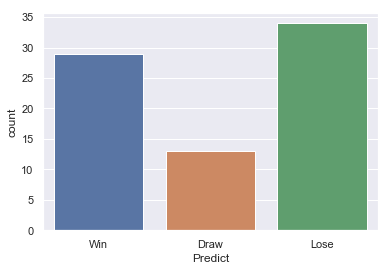

In [12]:
sns.set()
sns.countplot(data=arsenal,
              x='Predict', order=['Win', 'Draw', 'Lose'])

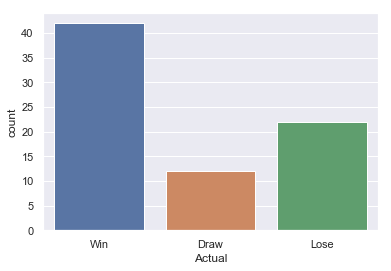

In [13]:
sns.set()
sns.countplot(data=arsenal,
              x='Actual', order=['Win', 'Draw', 'Lose'])

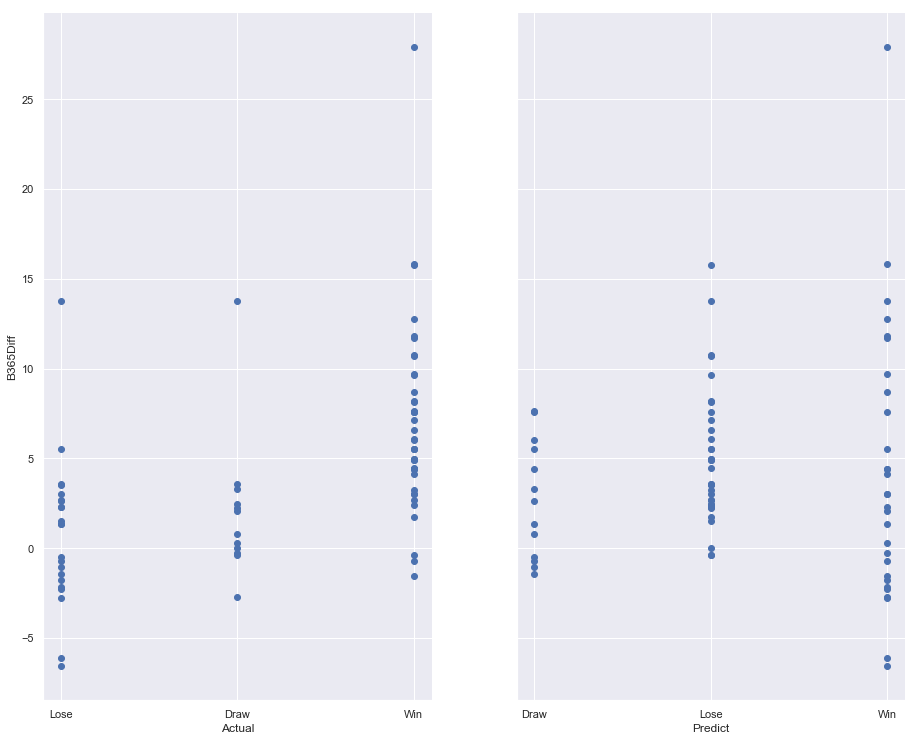

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
sns.set()
g = sns.PairGrid(arsenal,
                x_vars=['Actual', 'Predict'],
                y_vars=['B365Diff'])
g.fig.set_size_inches(15,15)
g = g.map(plt.scatter)

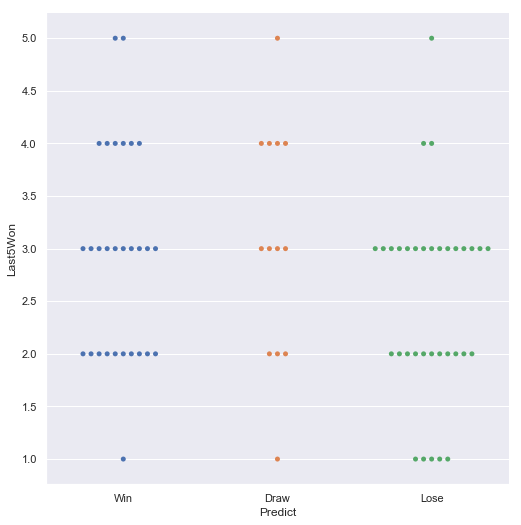

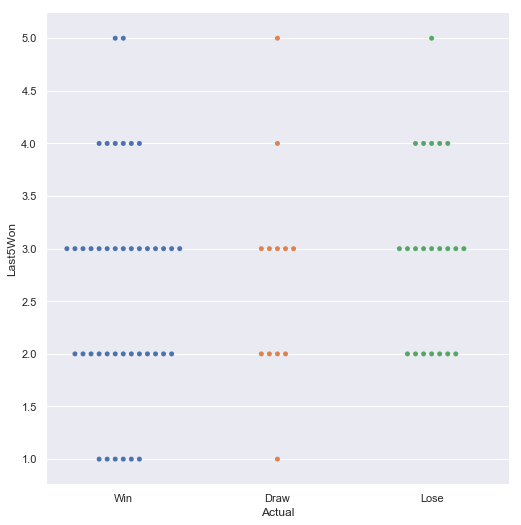

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
sns.set()
sns.catplot(x='Predict', y='Last5Won', data=arsenal, order=['Win', 'Draw', 'Lose'],kind="swarm").fig.set_size_inches(8,8)
sns.catplot(x='Actual', y='Last5Won', data=arsenal, order=['Win', 'Draw', 'Lose'], kind="swarm").fig.set_size_inches(8,8)

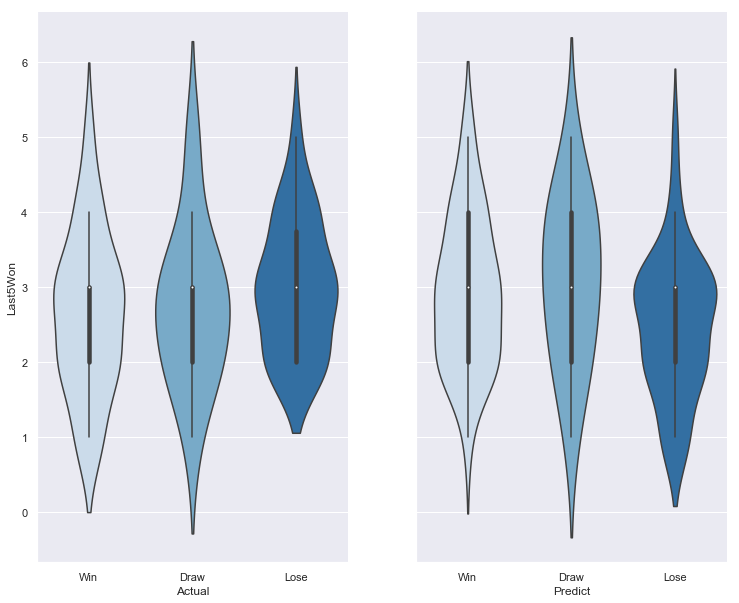

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
sns.set()
g = sns.PairGrid(arsenal,
                x_vars=['Actual', 'Predict'],
                y_vars=['Last5Won'])
g.map(sns.violinplot, order=['Win', 'Draw', 'Lose'], palette="Blues").fig.set_size_inches(12,12)
# sns.violinplot(x='Predict', y='Last5Won', data=arsenal, order=['Win', 'Draw', 'Lose']).fig.set_size_inches(8,8)
# sns.violinplot(x='Actual', y='Last5Won', data=arsenal, order=['Win', 'Draw', 'Lose']).fig.set_size_inches(8,8)

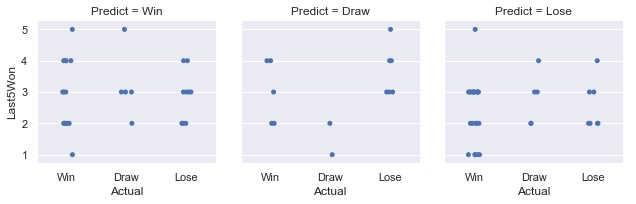

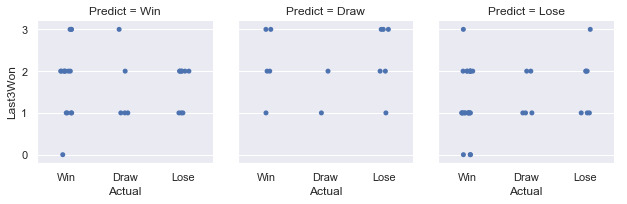

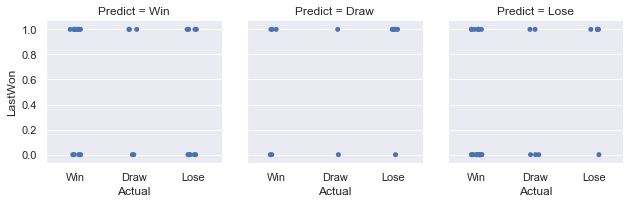

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
sns.set()
g = sns.FacetGrid(arsenal, col="Predict", col_order=['Win', 'Draw', 'Lose'])
g.map(sns.stripplot, 'Actual', 'Last5Won', order=['Win', 'Draw', 'Lose'])
g = sns.FacetGrid(arsenal, col="Predict", col_order=['Win', 'Draw', 'Lose'])
g.map(sns.stripplot, 'Actual', 'Last3Won', order=['Win', 'Draw', 'Lose'])
g = sns.FacetGrid(arsenal, col="Predict", col_order=['Win', 'Draw', 'Lose'])
g.map(sns.stripplot, 'Actual', 'LastWon', order=['Win', 'Draw', 'Lose'])

In [18]:
chart_data = {}
chart_data_all = None
for team, dataset in teams.items():
    chart_data_team = pd.DataFrame(dataset[0])
    chart_data_team = chart_data_team[(chart_data_team['Year'] >= validate_year) | (chart_data_team['Year'] >= test_year)]
    chart_data_team['Actual'] = dataset[1]['Result']
    i = total[total.index.isin(chart_data_team.index)]
    chart_data_team.loc[i.index, 'Predict'] = i['Predict']
    chart_data_team['Point'] = np.where(chart_data_team['Actual'] == 'Win', 3,
                                 np.where(chart_data_team['Actual'] == 'Draw', 1, 0)
                                  )
    chart_data_team['PointPredict'] = np.where(chart_data_team['Predict'] == 'Win', 3,
                                 np.where(chart_data_team['Predict'] == 'Draw', 1, 0)
                                  )
    for key, groupByYear in chart_data_team.groupby('Year'):
        chart_data_team.loc[groupByYear.index, 'MatchNo'] = range(1,len(groupByYear['Actual'])+1)
        chart_data_team.loc[groupByYear.index, 'TotalPoints'] = np.nancumsum(groupByYear['Point'])
        chart_data_team.loc[groupByYear.index, 'TotalPointsPredict'] = np.nancumsum(groupByYear['PointPredict'])
        
    chart_data_team['Team'] = team
    chart_data[team] = chart_data_team
    if chart_data_all is None:
        chart_data_all = chart_data_team
    else:
        chart_data_all = chart_data_all.append(chart_data_team, ignore_index=True, sort=False)
chart_data_all

,Year,HomeMatch,B365Say,B365Diff,Last5AgainstThisOpponentWon,Last5AgainstThisOpponentDraw,Last3AgainstThisOpponentWon,Last3AgainstThisOpponentDraw,LastAgainstThisOpponentWon,LastAgainstThisOpponentDraw,...,LastWon,LastDraw,Actual,Predict,Point,PointPredict,MatchNo,TotalPoints,TotalPointsPredict,Team
0,2016,True,0,-0.70,1.0,3.0,1.0,2.0,0.0,1.0,...,1.0,0.0,Lose,Draw,0,1,1.0,0.0,1.0,Arsenal
1,2016,False,0,-0.38,0.0,0.0,3.0,0.0,1.0,0.0,...,0.0,0.0,Draw,Lose,1,0,2.0,1.0,1.0,Arsenal
2,2016,False,1,3.27,0.0,0.0,3.0,0.0,1.0,0.0,...,0.0,1.0,Win,Lose,3,0,3.0,4.0,1.0,Arsenal
3,2016,True,1,4.93,1.0,2.0,0.0,1.0,0.0,1.0,...,1.0,0.0,Win,Lose,3,0,4.0,7.0,1.0,Arsenal
4,2016,False,1,4.40,4.0,1.0,2.0,1.0,1.0,0.0,...,1.0,0.0,Win,Win,3,3,5.0,10.0,4.0,Arsenal
5,2016,True,0,-0.70,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,Win,Win,3,3,6.0,13.0,7.0,Arsenal
6,2016,False,1,7.60,0.0,0.0,3.0,0.0,1.0,0.0,...,1.0,0.0,Win,Draw,3,1,7.0,16.0,8.0,Arsenal
7,2016,True,1,9.71,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,Win,Win,3,3,8.0,19.0,11.0,Arsenal
8,2016,True,1,13.75,1.0,3.0,1.0,2.0,1.0,0.0,...,1.0,0.0,Draw,Win,1,3,9.0,20.0,14.0,Arsenal
9,2016,False,1,7.60,3.0,2.0,1.0,2.0,0.0,1.0,...,0.0,1.0,Win,Win,3,3,10.0,23.0,17.0,Arsenal


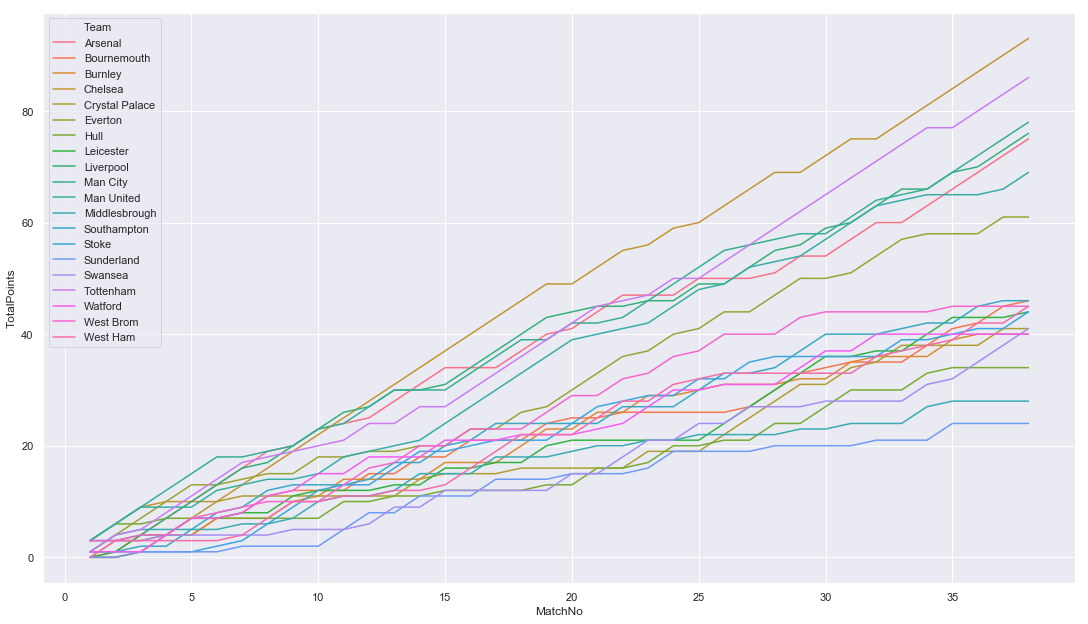

In [19]:
sns.set()
g = sns.lineplot(data=chart_data_all[chart_data_all['Year'] == 2016], x='MatchNo', y='TotalPoints', hue='Team')
g.figure.set_size_inches(18.5, 10.5)
# sns.despine()

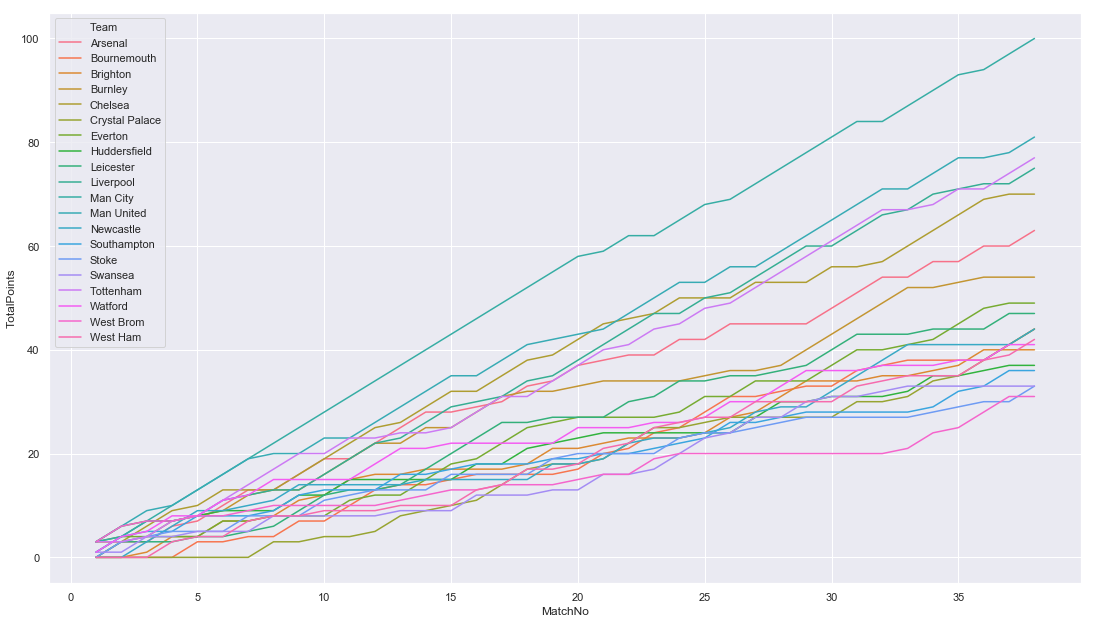

In [20]:
sns.set()
g = sns.lineplot(data=chart_data_all[chart_data_all['Year'] == 2017], x='MatchNo', y='TotalPoints', hue='Team')
g.figure.set_size_inches(18.5, 10.5)
# sns.despine()

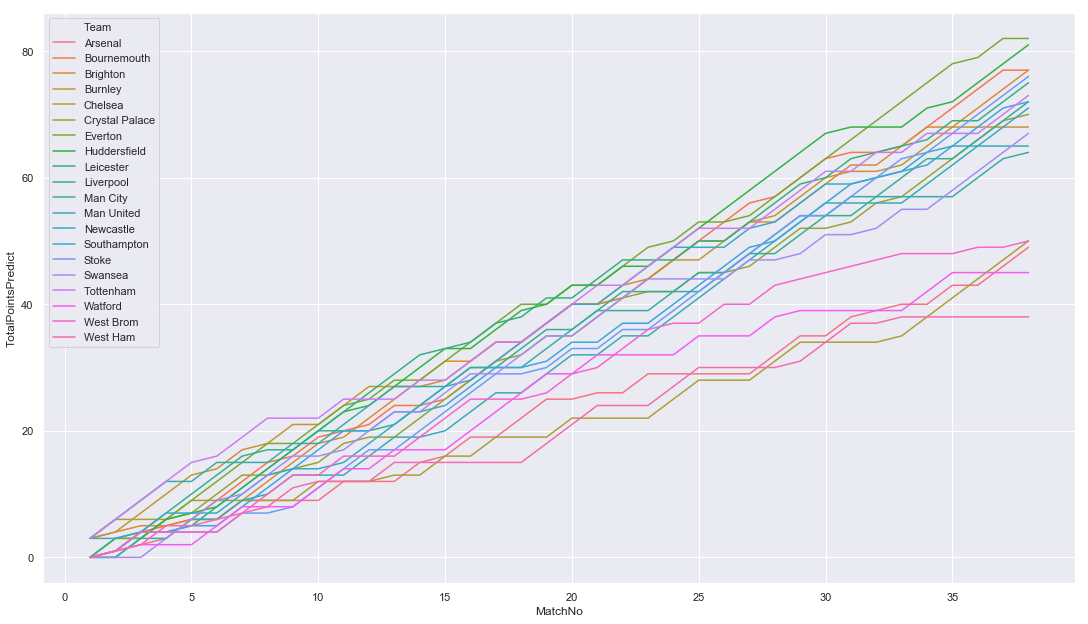

In [21]:

sns.set()
g = sns.lineplot(data=chart_data_all[chart_data_all['Year'] == 2017], x='MatchNo', y='TotalPointsPredict', hue='Team')
g.figure.set_size_inches(18.5, 10.5)
# sns.despine()

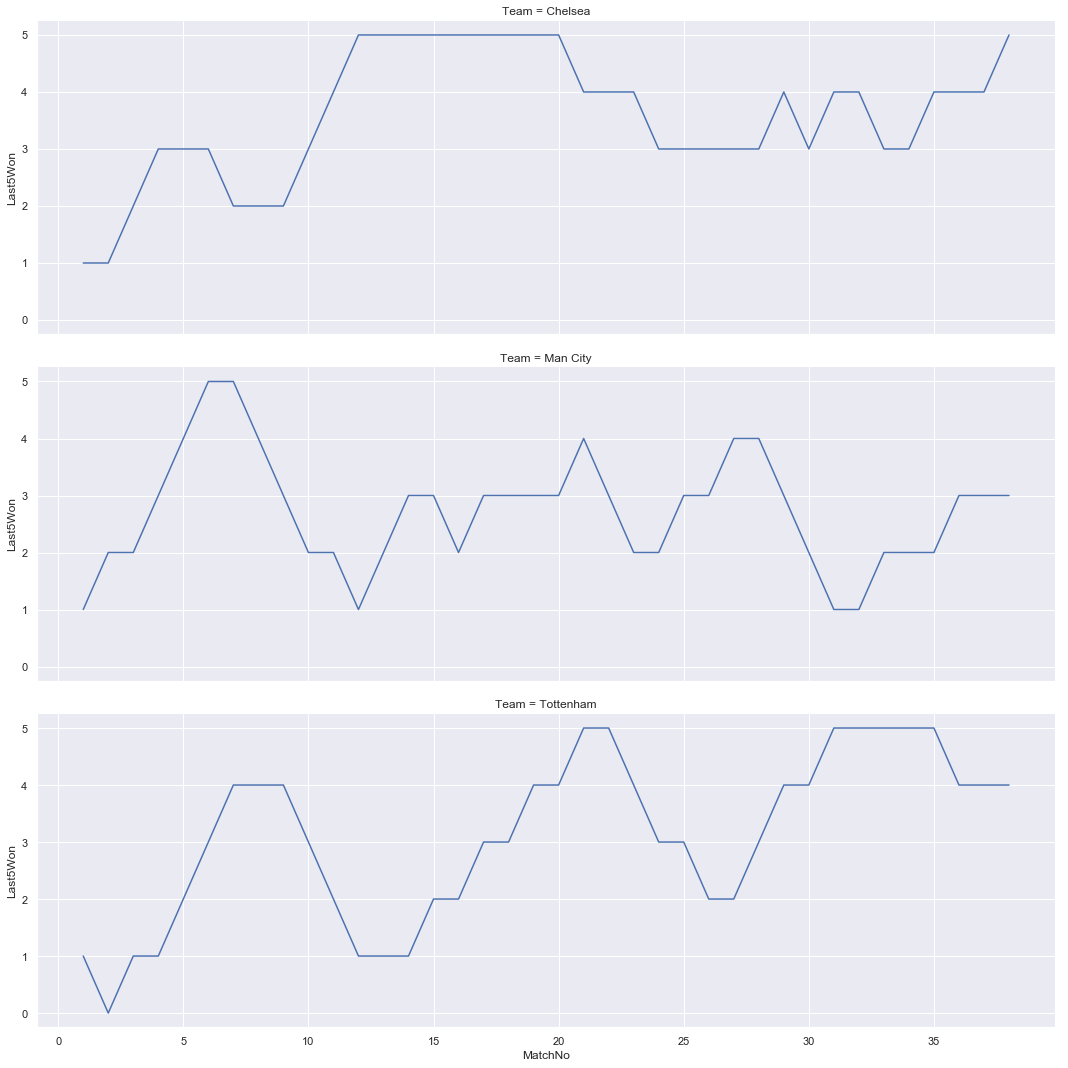

In [22]:
data = chart_data_all[(chart_data_all['Year'] == 2016) & chart_data_all['Team'].isin(['Chelsea', 'Tottenham', 'Man City'])]
sns.set()
g = sns.FacetGrid(data,
                row='Team',
                )
g.fig.set_size_inches(15,15)
g = g.map(sns.lineplot, 'MatchNo', 'Last5Won')

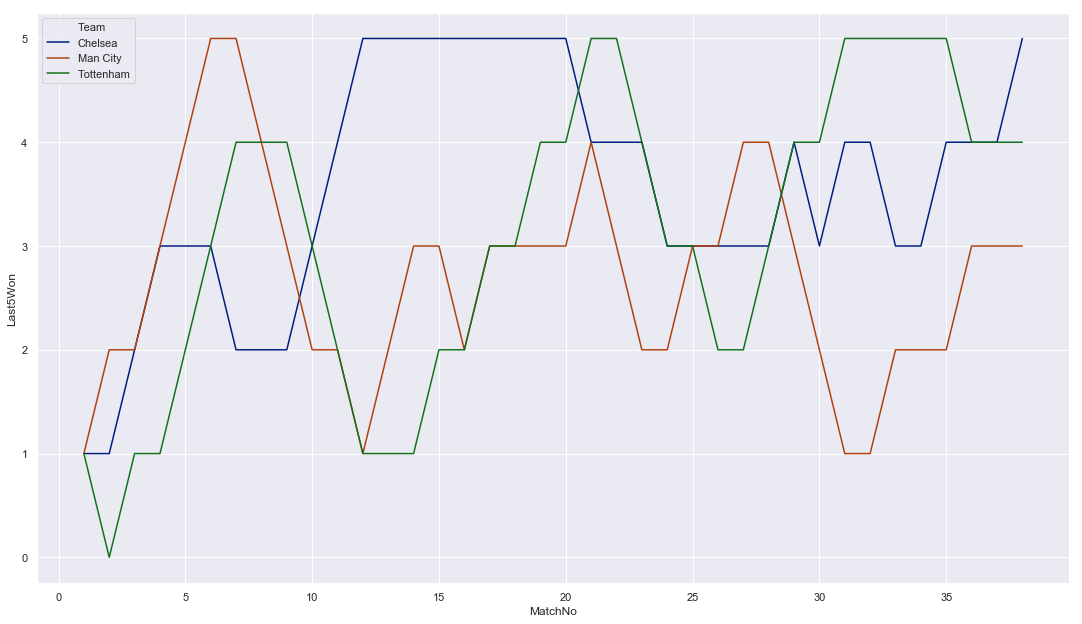

In [23]:
# chelsea = chart_data['Chelsea']
# print(chelsea[chelsea['Year'] == 2016][['MatchNo', 'Last5Won', 'Year']])
sns.set()
g = sns.lineplot(x='MatchNo', y='Last5Won', hue='Team', 
                 palette=sns.color_palette('dark', 3),
#                  palette=sns.color_palette([chelsea_blue, mancity_blue, tottenham_blue]),
                 data=chart_data_all[(chart_data_all['Year'] == 2016) & chart_data_all['Team'].isin(['Chelsea', 'Tottenham', 'Man City'])])
#                  data=chart_data_all[(chart_data_all['Year'] == 2016) & chart_data_all['Team'].isin(['Chelsea', 'Tottenham', 'Man City', 'Liverpool', 'Arsenal', 'Man United'])])
g.figure.set_size_inches(18.5, 10.5)

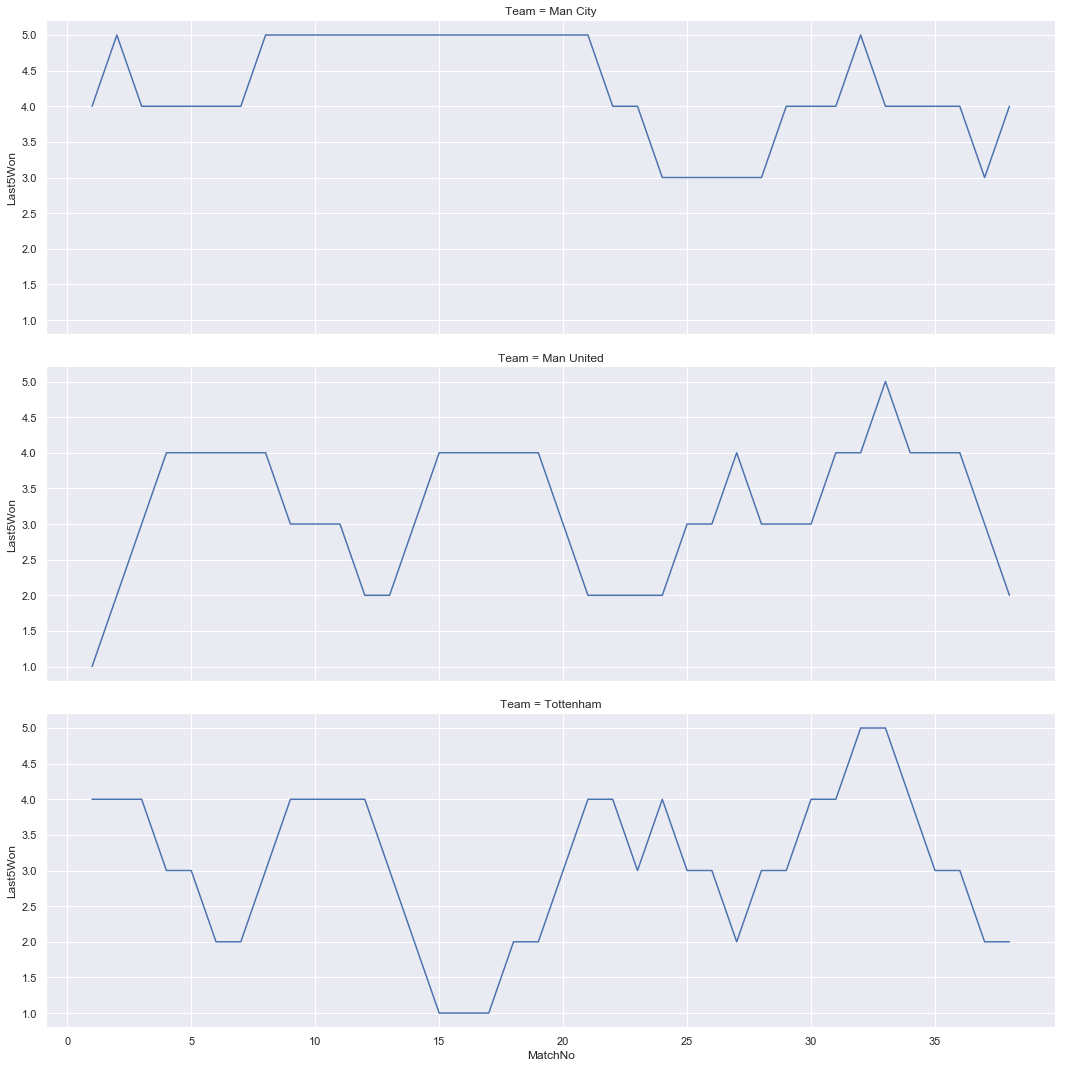

In [24]:
data = chart_data_all[(chart_data_all['Year'] == 2017) & chart_data_all['Team'].isin(['Man City', 'Man United', 'Tottenham'])]
sns.set()
g = sns.FacetGrid(data,
                row='Team',
                )
g.fig.set_size_inches(15,15)
g = g.map(sns.lineplot, 'MatchNo', 'Last5Won')

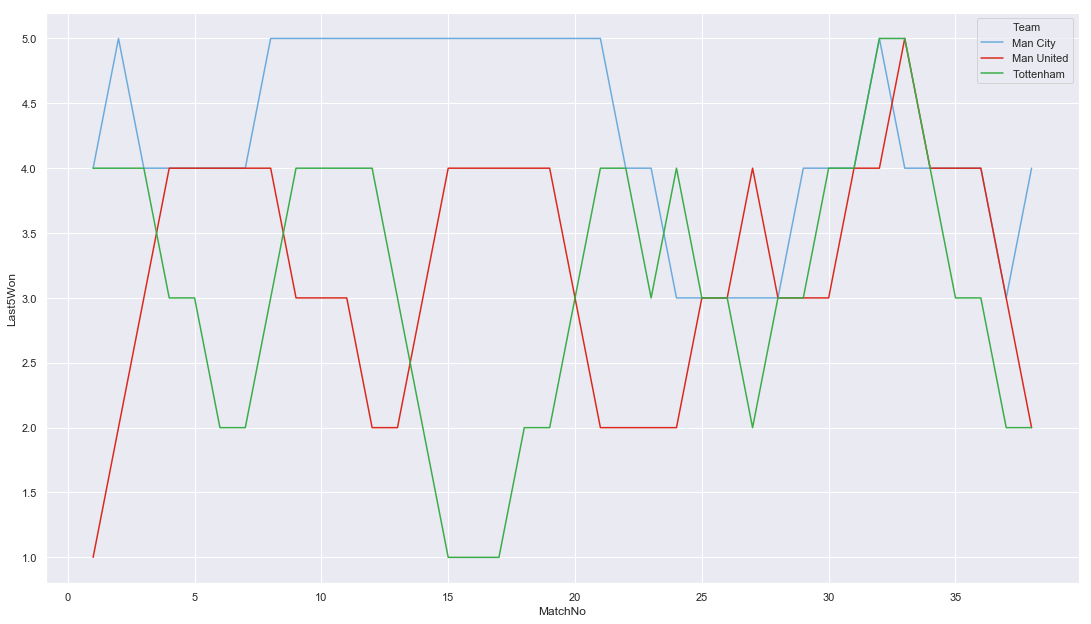

In [25]:
sns.set()
g = sns.lineplot(x='MatchNo', y='Last5Won', hue='Team', 
#                  palette=sns.color_palette('dark', 3),
                 palette=sns.color_palette([mancity_blue, manutd_red, sns.xkcd_rgb["medium green"]]),
                 data=chart_data_all[(chart_data_all['Year'] == 2017) & chart_data_all['Team'].isin(['Man City', 'Man United', 'Tottenham'])])
#                  data=chart_data_all[(chart_data_all['Year'] == 2016) & chart_data_all['Team'].isin(['Chelsea', 'Tottenham', 'Man City', 'Liverpool', 'Arsenal', 'Man United'])])
g.figure.set_size_inches(18.5, 10.5)

/Users/vachara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.


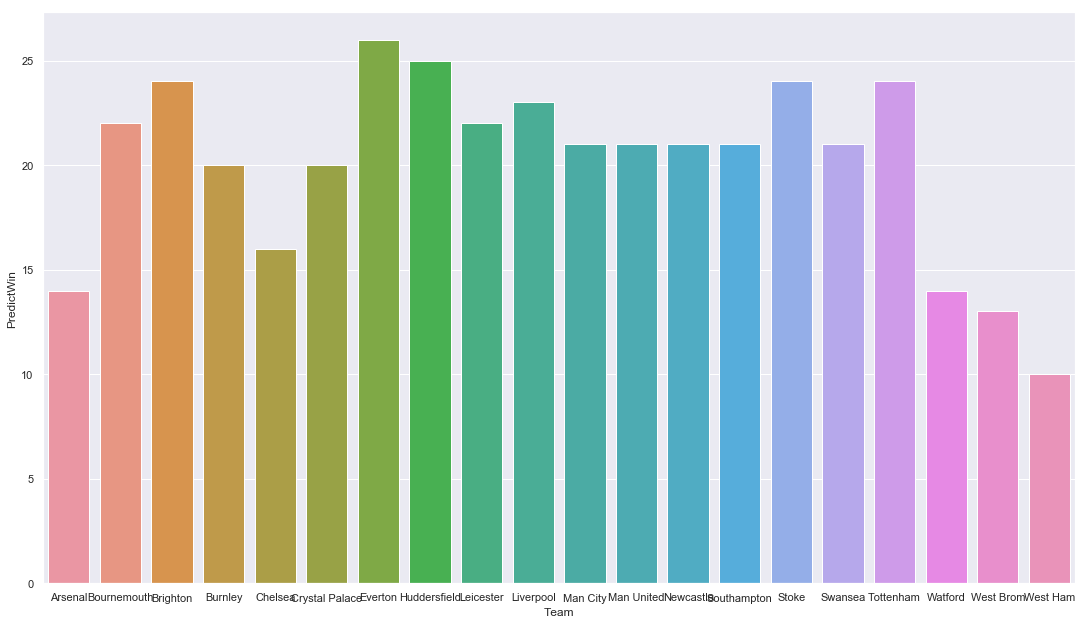

In [77]:
data = chart_data_all[(chart_data_all['Year'] == 2017)]
win_count = data[data['Predict'] == 'Win'].groupby(['Team'])['Predict'].agg({'PredictWin':'count'})
win_count['Team'] = win_count.index
# win_count['Team']
sns.set()
g = sns.barplot(x='Team', y='PredictWin', data=win_count)
g.figure.set_size_inches(18.5, 10.5)

/Users/vachara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


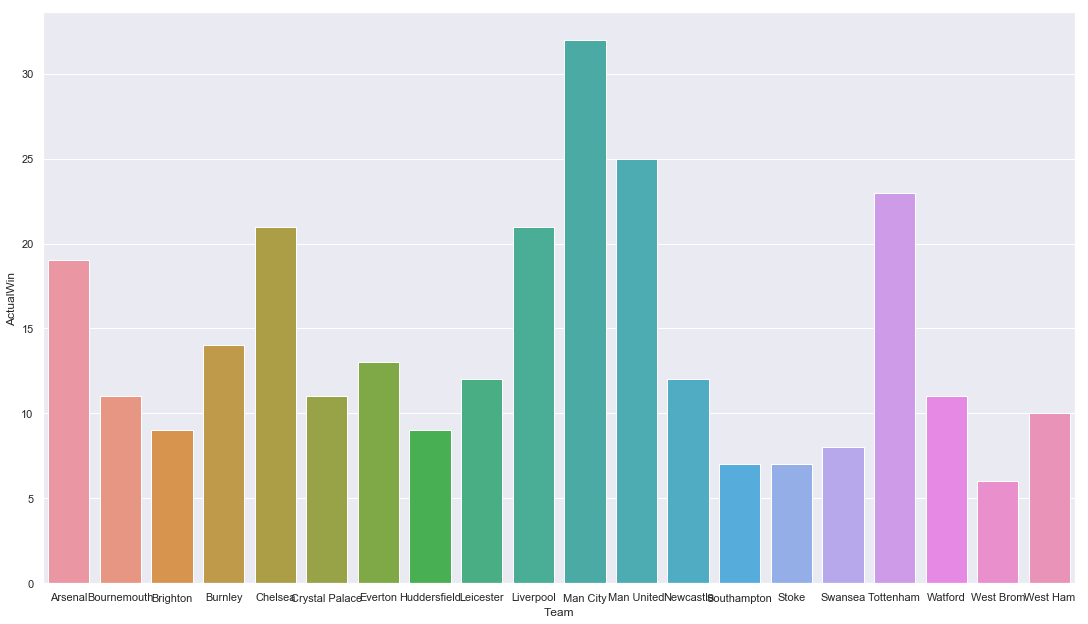

In [78]:
data = chart_data_all[(chart_data_all['Year'] == 2017)]
win_count = data[data['Actual'] == 'Win'].groupby(['Team'])['Actual'].agg({'ActualWin':'count'})
win_count['Team'] = win_count.index
# win_count['Team']
sns.set()
g = sns.barplot(x='Team', y='ActualWin', data=win_count)
g.figure.set_size_inches(18.5, 10.5)